<a href="https://colab.research.google.com/github/Sujoy-004/Chat-Analyzer-Pro/blob/main/notebooks/04_relationship_health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cell 1 : Set up environment and load data

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [15]:
# Load the parsed chat data
url = "https://raw.githubusercontent.com/Sujoy-004/Chat-Analyzer-Pro/refs/heads/main/data/processed/example_parsed.csv"
df = pd.read_csv(url)

# Convert datetime column to proper datetime format
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)

In [17]:
print(df.shape)
print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"Participants: {', '.join(df['sender'].unique())}")
print("\nSample data:")
print(df.head(3).to_string())

(27, 7)
Date range: 2023-12-25 09:30:00 to 2023-12-27 08:15:00
Participants: Alice, Bob

Sample data:
             datetime sender                                                                    message        date      time  hour  message_length
0 2023-12-25 09:30:00  Alice                                                        Merry Christmas! 🎄🎅  2023-12-25  09:30:00     9              19
1 2023-12-25 09:32:00    Bob                 Merry Christmas to you too! Hope you're having a great day  2023-12-25  09:32:00     9              58
2 2023-12-25 09:35:00  Alice  Thanks! Opening presents with family right now Family time is the best ❤️  2023-12-25  09:35:00     9              73


## Cell 2 : Calculate conversation initiation patterns

In [18]:
def calculate_conversation_initiators(df):
    """Calculate who initiates conversations more often"""

    # Sort by datetime to ensure proper sequence
    df_sorted = df.sort_values('datetime').reset_index(drop=True)

    # Define conversation gap threshold (30 minutes)
    conversation_gap = timedelta(minutes=30)

    # Identify conversation starters
    conversation_starters = []
    previous_time = None

    for idx, row in df_sorted.iterrows():
        current_time = row['datetime']

        # First message or gap > 30 minutes = conversation starter
        if previous_time is None or (current_time - previous_time) > conversation_gap:
            conversation_starters.append({
                'datetime': current_time,
                'initiator': row['sender'],
                'message': row['message']
            })

        previous_time = current_time

    return pd.DataFrame(conversation_starters)

# Calculate initiators
initiators_df = calculate_conversation_initiators(df)

In [19]:
print(f"Total conversations identified: {len(initiators_df)}")
print("\nConversation starters:")
for idx, row in initiators_df.iterrows():
    print(f"{row['datetime'].strftime('%Y-%m-%d %H:%M')} - {row['initiator']}: {row['message'][:50]}...")

Total conversations identified: 6

Conversation starters:
2023-12-25 09:30 - Alice: Merry Christmas! 🎄🎅...
2023-12-25 10:15 - Bob: That sounds wonderful! I'm cooking dinner for ever...
2023-12-25 11:30 - Bob: Beautiful tree! 😍 Our dinner is almost ready...
2023-12-25 14:30 - Bob: <Media omitted>...
2023-12-26 08:00 - Alice: Good morning! How was your evening?...
2023-12-27 07:00 - Alice: Happy Wednesday! Back to reality today 😅...


In [20]:
# Calculate initiation ratio
initiation_counts = initiators_df['initiator'].value_counts()
total_conversations = len(initiators_df)

print(f"\n📈 Initiation Statistics:")
for person, count in initiation_counts.items():
    percentage = (count / total_conversations) * 100
    print(f"{person}: {count}/{total_conversations} conversations ({percentage:.1f}%)")


📈 Initiation Statistics:
Alice: 3/6 conversations (50.0%)
Bob: 3/6 conversations (50.0%)


In [21]:
# Calculate balance score (closer to 50% = more balanced)
alice_percentage = (initiation_counts.get('Alice', 0) / total_conversations) * 100
bob_percentage = (initiation_counts.get('Bob', 0) / total_conversations) * 100
balance_score = 100 - abs(alice_percentage - 50)

print(f"\n⚖️ Conversation Balance Score: {balance_score:.1f}/100")
print("(100 = perfectly balanced, 0 = one person always initiates)")


⚖️ Conversation Balance Score: 100.0/100
(100 = perfectly balanced, 0 = one person always initiates)


##Cell 3 : Calculate response time patterns and engagement metrics

In [22]:
def calculate_response_times(df):
    """Calculate response times between participants"""

    df_sorted = df.sort_values('datetime').reset_index(drop=True)
    response_data = []

    for idx in range(1, len(df_sorted)):
        current_msg = df_sorted.iloc[idx]
        previous_msg = df_sorted.iloc[idx-1]

        # Only count responses between different people
        if current_msg['sender'] != previous_msg['sender']:
            response_time = current_msg['datetime'] - previous_msg['datetime']
            response_minutes = response_time.total_seconds() / 60

            response_data.append({
                'responder': current_msg['sender'],
                'original_sender': previous_msg['sender'],
                'response_time_minutes': response_minutes,
                'response_time_hours': response_minutes / 60,
                'datetime': current_msg['datetime'],
                'original_message': previous_msg['message'][:30] + "...",
                'response_message': current_msg['message'][:30] + "..."
            })

    return pd.DataFrame(response_data)

# Calculate response times
response_df = calculate_response_times(df)

In [4]:
print(f"Total responses analyzed: {len(response_df)}")

if len(response_df) > 0:
    # Show detailed response times
    print("\n📱 Response Details:")
    for idx, row in response_df.iterrows():
        if row['response_time_minutes'] < 60:
            time_str = f"{row['response_time_minutes']:.1f} minutes"
        else:
            time_str = f"{row['response_time_hours']:.1f} hours"

        print(f"{row['datetime'].strftime('%m-%d %H:%M')} - {row['responder']} responded in {time_str}")
        print(f"   └─ To: '{row['original_message']}'")
        print(f"   └─ With: '{row['response_message']}'")
        print()

    # Calculate statistics by person
    print("📊 Response Time Statistics by Person:")
    for person in response_df['responder'].unique():
        person_responses = response_df[response_df['responder'] == person]
        avg_response = person_responses['response_time_minutes'].mean()
        median_response = person_responses['response_time_minutes'].median()

        print(f"\n{person}:")
        print(f"  • Average response time: {avg_response:.1f} minutes")
        print(f"  • Median response time: {median_response:.1f} minutes")
        print(f"  • Fastest response: {person_responses['response_time_minutes'].min():.1f} minutes")
        print(f"  • Slowest response: {person_responses['response_time_minutes'].max():.1f} minutes")

    # Overall responsiveness score
    overall_avg = response_df['response_time_minutes'].mean()
    print(f"\n🚀 Overall Average Response Time: {overall_avg:.1f} minutes")

    # Responsiveness score (inverse relationship with time)
    if overall_avg <= 5:
        responsiveness_score = 100
    elif overall_avg <= 30:
        responsiveness_score = 90 - (overall_avg - 5) * 2
    else:
        responsiveness_score = max(10, 50 - (overall_avg - 30) * 0.5)

    print(f"📈 Responsiveness Score: {responsiveness_score:.1f}/100")
else:
    print("No response patterns found in this dataset.")

⏱️ Response Time Analysis
Total responses analyzed: 19

📱 Response Details:
12-25 09:32 - Bob responded in 2.0 minutes
   └─ To: 'Merry Christmas! 🎄🎅...'
   └─ With: 'Merry Christmas to you too! Ho...'

12-25 09:35 - Alice responded in 3.0 minutes
   └─ To: 'Merry Christmas to you too! Ho...'
   └─ With: 'Thanks! Opening presents with ...'

12-25 10:15 - Bob responded in 40.0 minutes
   └─ To: 'Thanks! Opening presents with ...'
   └─ With: 'That sounds wonderful! I'm coo...'

12-25 10:16 - Alice responded in 1.0 minutes
   └─ To: 'That sounds wonderful! I'm coo...'
   └─ With: '<Media omitted>...'

12-25 11:30 - Bob responded in 1.2 hours
   └─ To: 'Here's our Christmas tree!...'
   └─ With: 'Beautiful tree! 😍 Our dinner i...'

12-25 11:45 - Alice responded in 15.0 minutes
   └─ To: 'Beautiful tree! 😍 Our dinner i...'
   └─ With: 'Can't wait to see photos!...'

12-25 14:30 - Bob responded in 2.8 hours
   └─ To: 'Can't wait to see photos!...'
   └─ With: '<Media omitted>...'

12-25 14:

##Cell 4 : Calculate conversation dominance and engagement patterns

In [5]:
def calculate_dominance_metrics(df):
    """Calculate conversation dominance patterns"""

    # Message count dominance
    message_counts = df['sender'].value_counts()
    total_messages = len(df)

    print("💬 Message Volume Analysis")
    print("=" * 30)
    for person, count in message_counts.items():
        percentage = (count / total_messages) * 100
        print(f"{person}: {count} messages ({percentage:.1f}%)")

    # Word count dominance (using message_length as proxy)
    word_dominance = df.groupby('sender')['message_length'].agg(['sum', 'mean', 'count'])
    total_chars = word_dominance['sum'].sum()

    print(f"\n📝 Content Volume Analysis")
    print("=" * 30)
    for person in word_dominance.index:
        char_count = word_dominance.loc[person, 'sum']
        avg_length = word_dominance.loc[person, 'mean']
        percentage = (char_count / total_chars) * 100

        print(f"{person}:")
        print(f"  • Total characters: {char_count} ({percentage:.1f}%)")
        print(f"  • Average message length: {avg_length:.1f} characters")

    # Calculate consecutive message patterns (message bursts)
    consecutive_patterns = []
    current_streak = 1
    current_sender = df.iloc[0]['sender']

    for idx in range(1, len(df)):
        if df.iloc[idx]['sender'] == current_sender:
            current_streak += 1
        else:
            if current_streak > 1:
                consecutive_patterns.append({
                    'sender': current_sender,
                    'consecutive_count': current_streak,
                    'start_time': df.iloc[idx-current_streak]['datetime'],
                    'end_time': df.iloc[idx-1]['datetime']
                })
            current_sender = df.iloc[idx]['sender']
            current_streak = 1

    # Don't forget the last streak
    if current_streak > 1:
        consecutive_patterns.append({
            'sender': current_sender,
            'consecutive_count': current_streak,
            'start_time': df.iloc[-current_streak]['datetime'],
            'end_time': df.iloc[-1]['datetime']
        })

    print(f"\n🔥 Message Burst Patterns")
    print("=" * 30)
    if consecutive_patterns:
        for pattern in consecutive_patterns:
            print(f"{pattern['sender']}: {pattern['consecutive_count']} consecutive messages")
            print(f"   └─ {pattern['start_time'].strftime('%m-%d %H:%M')} to {pattern['end_time'].strftime('%H:%M')}")

        # Burst statistics
        burst_stats = {}
        for pattern in consecutive_patterns:
            sender = pattern['sender']
            if sender not in burst_stats:
                burst_stats[sender] = []
            burst_stats[sender].append(pattern['consecutive_count'])

        print(f"\n📊 Burst Statistics:")
        for sender, bursts in burst_stats.items():
            avg_burst = np.mean(bursts)
            max_burst = max(bursts)
            total_bursts = len(bursts)
            print(f"{sender}: {total_bursts} bursts, avg {avg_burst:.1f}, max {max_burst}")
    else:
        print("No message bursts detected (alternating conversation style)")

    return message_counts, word_dominance, consecutive_patterns

# Calculate dominance metrics
msg_counts, word_dom, bursts = calculate_dominance_metrics(df)

# Calculate overall dominance score
alice_msg_pct = (msg_counts.get('Alice', 0) / len(df)) * 100
bob_msg_pct = (msg_counts.get('Bob', 0) / len(df)) * 100
dominance_balance = 100 - abs(alice_msg_pct - 50)

print(f"\n⚖️ Message Balance Score: {dominance_balance:.1f}/100")
print("(100 = perfectly balanced, 0 = one person dominates completely)")

💬 Message Volume Analysis
Alice: 14 messages (51.9%)
Bob: 13 messages (48.1%)

📝 Content Volume Analysis
Alice:
  • Total characters: 519 (50.8%)
  • Average message length: 37.1 characters
Bob:
  • Total characters: 502 (49.2%)
  • Average message length: 38.6 characters

🔥 Message Burst Patterns
Alice: 2 consecutive messages
   └─ 12-25 10:16 to 10:17
Bob: 2 consecutive messages
   └─ 12-25 14:30 to 14:31
Alice: 2 consecutive messages
   └─ 12-25 15:15 to 08:00
Bob: 2 consecutive messages
   └─ 12-26 08:30 to 08:31
Alice: 2 consecutive messages
   └─ 12-26 09:00 to 09:01
Bob: 2 consecutive messages
   └─ 12-27 07:30 to 07:31
Alice: 2 consecutive messages
   └─ 12-27 08:00 to 08:01

📊 Burst Statistics:
Alice: 4 bursts, avg 2.0, max 2
Bob: 3 bursts, avg 2.0, max 2

⚖️ Message Balance Score: 98.1/100
(100 = perfectly balanced, 0 = one person dominates completely)


##Cell 5 : Calculate comprehensive relationship health score and create visualizations

In [23]:
def calculate_relationship_health_score(df, msg_counts, response_df, initiators_df):
    """Calculate comprehensive relationship health score"""

    # 1. Communication Balance (25 points)
    alice_msg_pct = (msg_counts.get('Alice', 0) / len(df)) * 100
    balance_score = 100 - abs(alice_msg_pct - 50)
    balance_points = (balance_score / 100) * 25

    # 2. Initiation Balance (20 points)
    alice_init_pct = (initiators_df['initiator'].value_counts().get('Alice', 0) / len(initiators_df)) * 100
    init_balance = 100 - abs(alice_init_pct - 50)
    init_points = (init_balance / 100) * 20

    # 3. Response Quality (25 points)
    if len(response_df) > 0:
        avg_response_time = response_df['response_time_minutes'].mean()
        if avg_response_time <= 30:
            response_points = 25
        elif avg_response_time <= 120:
            response_points = 25 - ((avg_response_time - 30) / 90) * 15
        else:
            response_points = max(5, 10 - ((avg_response_time - 120) / 60) * 2)
    else:
        response_points = 15  # Default if no responses

    # 4. Conversation Consistency (15 points)
    date_range = (df['datetime'].max() - df['datetime'].min()).days + 1
    conversations_per_day = len(initiators_df) / date_range
    if conversations_per_day >= 2:
        consistency_points = 15
    elif conversations_per_day >= 1:
        consistency_points = conversations_per_day * 7.5
    else:
        consistency_points = conversations_per_day * 15

    # 5. Engagement Quality (15 points)
    avg_msg_length = df['message_length'].mean()
    if avg_msg_length >= 40:
        engagement_points = 15
    elif avg_msg_length >= 20:
        engagement_points = (avg_msg_length - 20) / 20 * 15
    else:
        engagement_points = avg_msg_length / 20 * 7.5

    # Calculate total score
    total_score = balance_points + init_points + response_points + consistency_points + engagement_points

    print(f"📊 Score Breakdown:")
    print(f"  1. Communication Balance: {balance_points:.1f}/25 points")
    print(f"  2. Initiation Balance: {init_points:.1f}/20 points")
    print(f"  3. Response Quality: {response_points:.1f}/25 points")
    print(f"  4. Conversation Consistency: {consistency_points:.1f}/15 points")
    print(f"  5. Engagement Quality: {engagement_points:.1f}/15 points")
    print(f"\n🎯 OVERALL RELATIONSHIP HEALTH SCORE: {total_score:.1f}/100")

    # Health interpretation
    if total_score >= 85:
        health_status = "Excellent 💚"
        interpretation = "Very healthy communication with great balance and engagement"
    elif total_score >= 70:
        health_status = "Good 💛"
        interpretation = "Healthy communication with room for minor improvements"
    elif total_score >= 55:
        health_status = "Fair 🧡"
        interpretation = "Decent communication but some areas need attention"
    else:
        health_status = "Needs Improvement ❤️"
        interpretation = "Communication patterns suggest some relationship challenges"

    print(f"\n📋 Health Status: {health_status}")
    print(f"💡 Interpretation: {interpretation}")

    return {
        'total_score': total_score,
        'balance_points': balance_points,
        'init_points': init_points,
        'response_points': response_points,
        'consistency_points': consistency_points,
        'engagement_points': engagement_points,
        'health_status': health_status,
        'interpretation': interpretation
    }

# Calculate comprehensive health score
health_metrics = calculate_relationship_health_score(df, msg_counts, response_df, initiators_df)

📊 Score Breakdown:
  1. Communication Balance: 24.5/25 points
  2. Initiation Balance: 20.0/20 points
  3. Response Quality: 14.3/25 points
  4. Conversation Consistency: 15.0/15 points
  5. Engagement Quality: 13.4/15 points

🎯 OVERALL RELATIONSHIP HEALTH SCORE: 87.2/100

📋 Health Status: Excellent 💚
💡 Interpretation: Very healthy communication with great balance and engagement


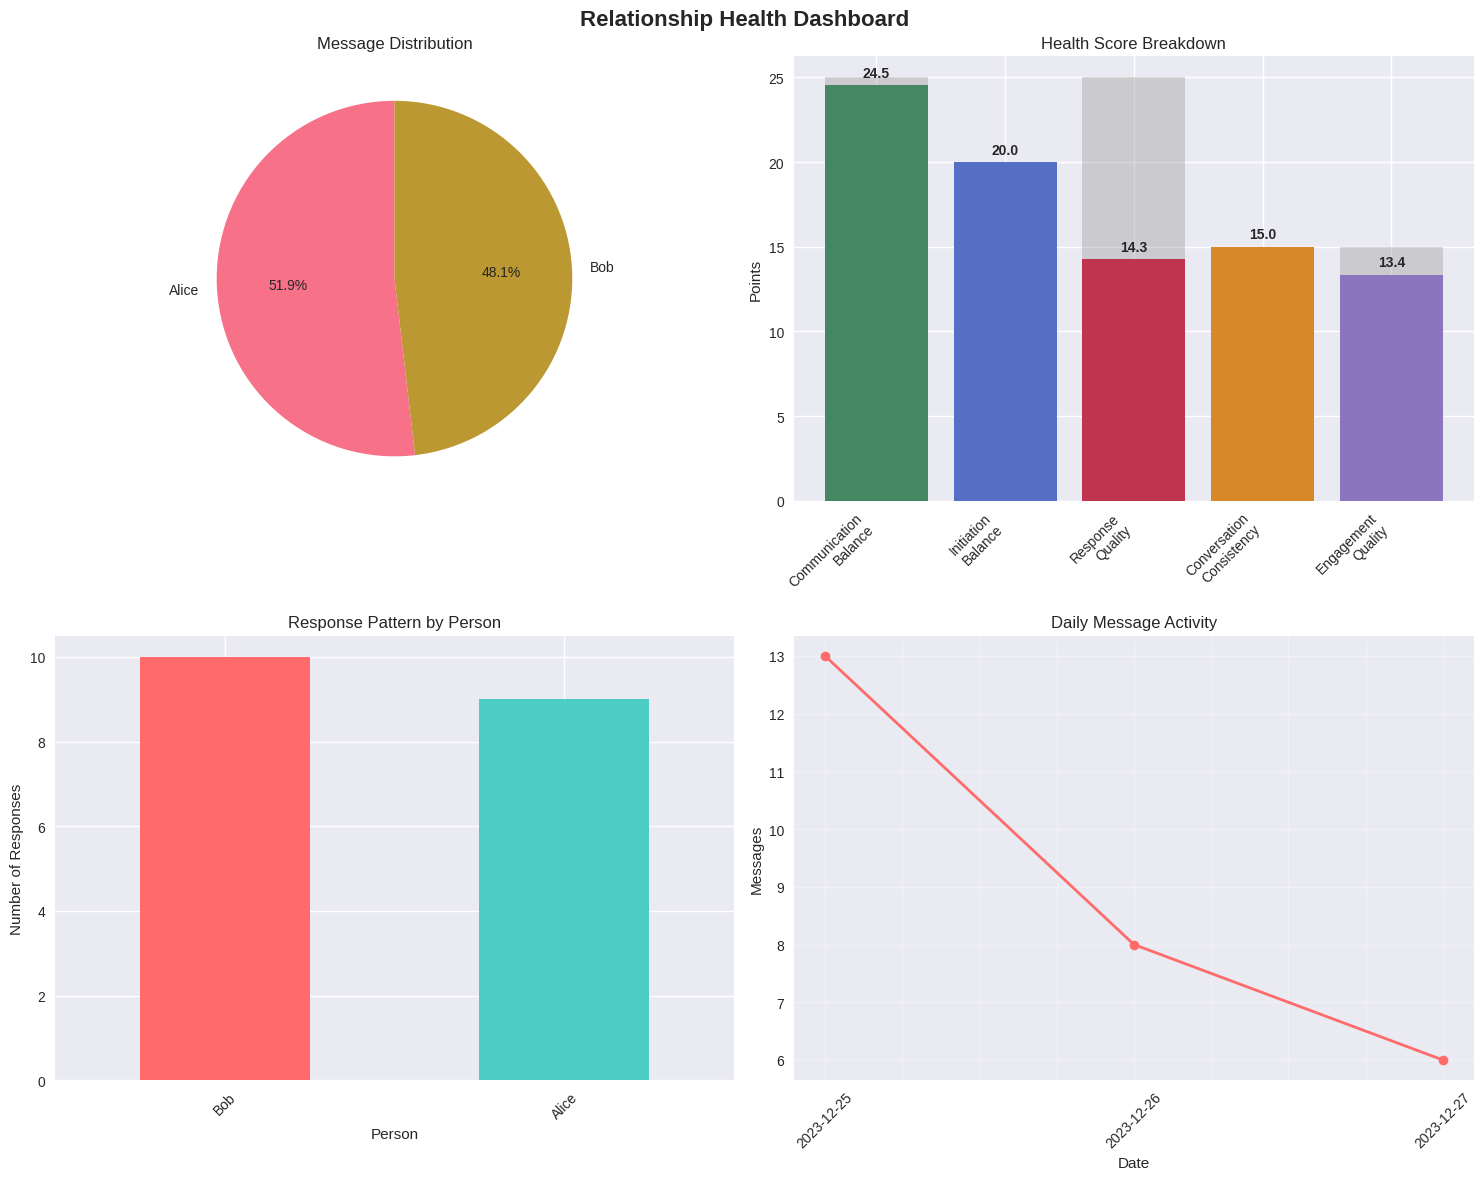


✅ Relationship health analysis complete!
📈 Overall Score: 87.2/100 - Excellent 💚


In [24]:
# Create visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Relationship Health Dashboard', fontsize=16, fontweight='bold')

# 1. Message Distribution
msg_counts.plot(kind='pie', ax=ax1, autopct='%1.1f%%', startangle=90)
ax1.set_title('Message Distribution')
ax1.set_ylabel('')

# 2. Score Breakdown
categories = ['Communication\nBalance', 'Initiation\nBalance', 'Response\nQuality',
              'Conversation\nConsistency', 'Engagement\nQuality']
scores = [health_metrics['balance_points'], health_metrics['init_points'],
          health_metrics['response_points'], health_metrics['consistency_points'],
          health_metrics['engagement_points']]
max_scores = [25, 20, 25, 15, 15]

x_pos = np.arange(len(categories))
bars = ax2.bar(x_pos, scores, color=['#2E8B57', '#4169E1', '#DC143C', '#FF8C00', '#9370DB'])
ax2.bar(x_pos, max_scores, alpha=0.3, color='gray')
ax2.set_title('Health Score Breakdown')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(categories, rotation=45, ha='right')
ax2.set_ylabel('Points')

# Add score labels on bars
for i, (score, max_score) in enumerate(zip(scores, max_scores)):
    ax2.text(i, score + 0.5, f'{score:.1f}', ha='center', fontweight='bold')

# 3. Response Time Distribution
if len(response_df) > 0:
    response_df['responder'].value_counts().plot(kind='bar', ax=ax3, color=['#FF6B6B', '#4ECDC4'])
    ax3.set_title('Response Pattern by Person')
    ax3.set_xlabel('Person')
    ax3.set_ylabel('Number of Responses')
    ax3.tick_params(axis='x', rotation=45)

# 4. Daily Activity Timeline
daily_activity = df.groupby('date').size()
daily_activity.plot(kind='line', marker='o', ax=ax4, color='#FF6B6B', linewidth=2)
ax4.set_title('Daily Message Activity')
ax4.set_xlabel('Date')
ax4.set_ylabel('Messages')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Relationship health analysis complete!")
print(f"📈 Overall Score: {health_metrics['total_score']:.1f}/100 - {health_metrics['health_status']}")

##Cell 6 : Test the existing relationship_health.py module with our data


In [25]:
def identify_conversation_starters(df, gap_threshold_minutes=60):
    """Identify conversation starters based on time gaps and date changes."""
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime').reset_index(drop=True)

    # Calculate time differences
    df['time_diff'] = df['datetime'].diff()
    df['time_diff_minutes'] = df['time_diff'].dt.total_seconds() / 60
    df['prev_sender'] = df['sender'].shift(1)
    df['is_conversation_starter'] = False

    # First message is always a conversation starter
    df.loc[0, 'is_conversation_starter'] = True

    # Mark conversation starters based on gaps or date changes
    for i in range(1, len(df)):
        current_time = df.loc[i, 'datetime']
        prev_time = df.loc[i-1, 'datetime']
        time_gap_minutes = (current_time - prev_time).total_seconds() / 60
        different_day = current_time.date() != prev_time.date()

        if time_gap_minutes > gap_threshold_minutes or different_day:
            df.loc[i, 'is_conversation_starter'] = True

    return df

In [26]:
def calculate_initiator_ratio(df):
    """Calculate who initiates conversations more often."""
    initiator_counts = df[df['is_conversation_starter']==True]['sender'].value_counts()
    total_conversations = df['is_conversation_starter'].sum()

    if total_conversations == 0:
        return {'error': 'No conversation starters found'}

    # Calculate ratios
    ratios = {}
    for sender, count in initiator_counts.items():
        ratios[f'{sender}_initiation_ratio'] = count / total_conversations

    # Balance score (1.0 = perfectly balanced)
    if len(initiator_counts) >= 2:
        balance_score = 1 - abs(initiator_counts.values[0] - initiator_counts.values[1]) / total_conversations
    else:
        balance_score = 0.0

    return {
        'initiator_counts': initiator_counts.to_dict(),
        'total_conversations': total_conversations,
        'balance_score': balance_score,
        **ratios
    }

In [27]:
# Prepare data with conversation starters
df_prepared = identify_conversation_starters(df, gap_threshold_minutes=30)

print(f"Conversation starters found: {df_prepared['is_conversation_starter'].sum()}")

# Show conversation starters
print("\n🚀 Conversation Starters:")
starters = df_prepared[df_prepared['is_conversation_starter']==True]
for idx, row in starters.iterrows():
    print(f"  {row['datetime'].strftime('%m-%d %H:%M')} - {row['sender']}: {row['message'][:40]}...")

# Calculate initiator metrics
initiator_results = calculate_initiator_ratio(df_prepared)
print(f"\n📊 Initiator Analysis:")
print(f"  • Total conversations: {initiator_results['total_conversations']}")
print(f"  • Balance score: {initiator_results['balance_score']:.3f}")

for person, count in initiator_results['initiator_counts'].items():
    ratio = count / initiator_results['total_conversations']
    print(f"  • {person}: {count} initiations ({ratio:.1%})")

print(f"\n🎯 Conversation initiation is {'well balanced' if initiator_results['balance_score'] > 0.8 else 'moderately balanced' if initiator_results['balance_score'] > 0.6 else 'imbalanced'}")

Conversation starters found: 6

🚀 Conversation Starters:
  12-25 09:30 - Alice: Merry Christmas! 🎄🎅...
  12-25 10:15 - Bob: That sounds wonderful! I'm cooking dinne...
  12-25 11:30 - Bob: Beautiful tree! 😍 Our dinner is almost r...
  12-25 14:30 - Bob: <Media omitted>...
  12-26 08:00 - Alice: Good morning! How was your evening?...
  12-27 07:00 - Alice: Happy Wednesday! Back to reality today 😅...

📊 Initiator Analysis:
  • Total conversations: 6
  • Balance score: 1.000
  • Alice: 3 initiations (50.0%)
  • Bob: 3 initiations (50.0%)

🎯 Conversation initiation is well balanced


##Cell 7 : Complete relationship health analysis with comprehensive visualizations

In [28]:
def analyze_response_patterns(df):
    """Analyze response lag patterns and responsiveness."""
    response_df = df[df['is_conversation_starter'] == False].copy()

    response_analysis = []
    for i, row in response_df.iterrows():
        prev_sender = row['prev_sender']
        current_sender = row['sender']
        response_time = row['time_diff_minutes']

        if prev_sender != current_sender and pd.notna(response_time):
            response_analysis.append({
                'responder': current_sender,
                'responded_to': prev_sender,
                'response_time_minutes': response_time,
                'datetime': row['datetime']
            })

    if not response_analysis:
        return {'error': 'No valid responses found'}

    response_analysis_df = pd.DataFrame(response_analysis)

    # Calculate statistics
    response_stats = response_analysis_df.groupby('responder')['response_time_minutes'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(2)

    overall_avg_response = response_analysis_df['response_time_minutes'].mean()

    # Balance scores
    if len(response_stats) >= 2:
        avg_times = response_stats['mean'].values
        response_balance = abs(avg_times[0] - avg_times[1])
        responsiveness_score = max(0, 1 - (overall_avg_response / 120))
        balance_score = max(0, 1 - (response_balance / 60))
    else:
        response_balance = 0
        responsiveness_score = max(0, 1 - (overall_avg_response / 120))
        balance_score = 1.0

    return {
        'response_stats': response_stats.to_dict(),
        'response_analysis_df': response_analysis_df,
        'overall_avg_response_minutes': overall_avg_response,
        'response_time_difference': response_balance,
        'responsiveness_score': responsiveness_score,
        'response_balance_score': balance_score,
        'total_responses_analyzed': len(response_analysis_df)
    }

In [29]:
def calculate_dominance_scores(df):
    """Calculate conversation dominance patterns."""
    total_messages = len(df)

    # Message count dominance
    message_counts = df['sender'].value_counts()
    if len(message_counts) >= 2:
        message_dominance_score = 1 - abs(message_counts.values[0] - message_counts.values[1]) / total_messages
    else:
        message_dominance_score = 0.0

    # Message length dominance
    if 'message_length' in df.columns:
        length_distribution = df.groupby('sender')['message_length'].sum()
        total_chars = df['message_length'].sum()
        if len(length_distribution) >= 2 and total_chars > 0:
            length_dominance_score = 1 - abs(length_distribution.values[0] - length_distribution.values[1]) / total_chars
        else:
            length_dominance_score = 1.0
        avg_lengths = df.groupby('sender')['message_length'].mean()
    else:
        length_dominance_score = 1.0
        length_distribution = pd.Series()
        avg_lengths = pd.Series()

    # Conversation control patterns
    conversation_endings = []
    for i in range(len(df)):
        if i == len(df) - 1 or (i < len(df) - 1 and df.loc[i+1, 'is_conversation_starter']):
            conversation_endings.append(df.loc[i, 'sender'])

    ending_counts = pd.Series(conversation_endings).value_counts()
    if len(ending_counts) >= 2:
        control_balance = 1 - abs(ending_counts.values[0] - ending_counts.values[1]) / len(conversation_endings)
    else:
        control_balance = 0.0

    # Composite dominance score
    composite_dominance = (message_dominance_score + length_dominance_score + control_balance) / 3

    return {
        'message_count_balance': message_dominance_score,
        'message_length_balance': length_dominance_score,
        'conversation_control_balance': control_balance,
        'composite_dominance_score': composite_dominance,
        'message_distribution': message_counts.to_dict(),
        'length_distribution': length_distribution.to_dict() if not length_distribution.empty else {},
        'avg_message_lengths': avg_lengths.to_dict() if not avg_lengths.empty else {},
        'conversation_enders': ending_counts.to_dict()
    }

In [30]:
# Calculate all metrics
response_metrics = analyze_response_patterns(df_prepared)
dominance_metrics = calculate_dominance_scores(df_prepared)

In [31]:
print("📱 Response Analysis:")
if 'error' not in response_metrics:
    print(f"  • Total responses analyzed: {response_metrics['total_responses_analyzed']}")
    print(f"  • Overall avg response time: {response_metrics['overall_avg_response_minutes']:.1f} minutes")
    print(f"  • Responsiveness score: {response_metrics['responsiveness_score']:.3f}")
    print(f"  • Response balance score: {response_metrics['response_balance_score']:.3f}")

    if 'mean' in response_metrics['response_stats']:
        print("  • Individual response stats:")
        for person, avg_time in response_metrics['response_stats']['mean'].items():
            print(f"    - {person}: avg {avg_time:.1f} minutes")

📱 Response Analysis:
  • Total responses analyzed: 15
  • Overall avg response time: 18.1 minutes
  • Responsiveness score: 0.849
  • Response balance score: 0.962
  • Individual response stats:
    - Alice: avg 17.0 minutes
    - Bob: avg 19.3 minutes


In [32]:
print(f"\n⚖️ Dominance Analysis:")
print(f"  • Message count balance: {dominance_metrics['message_count_balance']:.3f}")
print(f"  • Message length balance: {dominance_metrics['message_length_balance']:.3f}")
print(f"  • Conversation control balance: {dominance_metrics['conversation_control_balance']:.3f}")
print(f"  • Composite dominance score: {dominance_metrics['composite_dominance_score']:.3f}")


⚖️ Dominance Analysis:
  • Message count balance: 0.963
  • Message length balance: 0.983
  • Conversation control balance: 0.667
  • Composite dominance score: 0.871


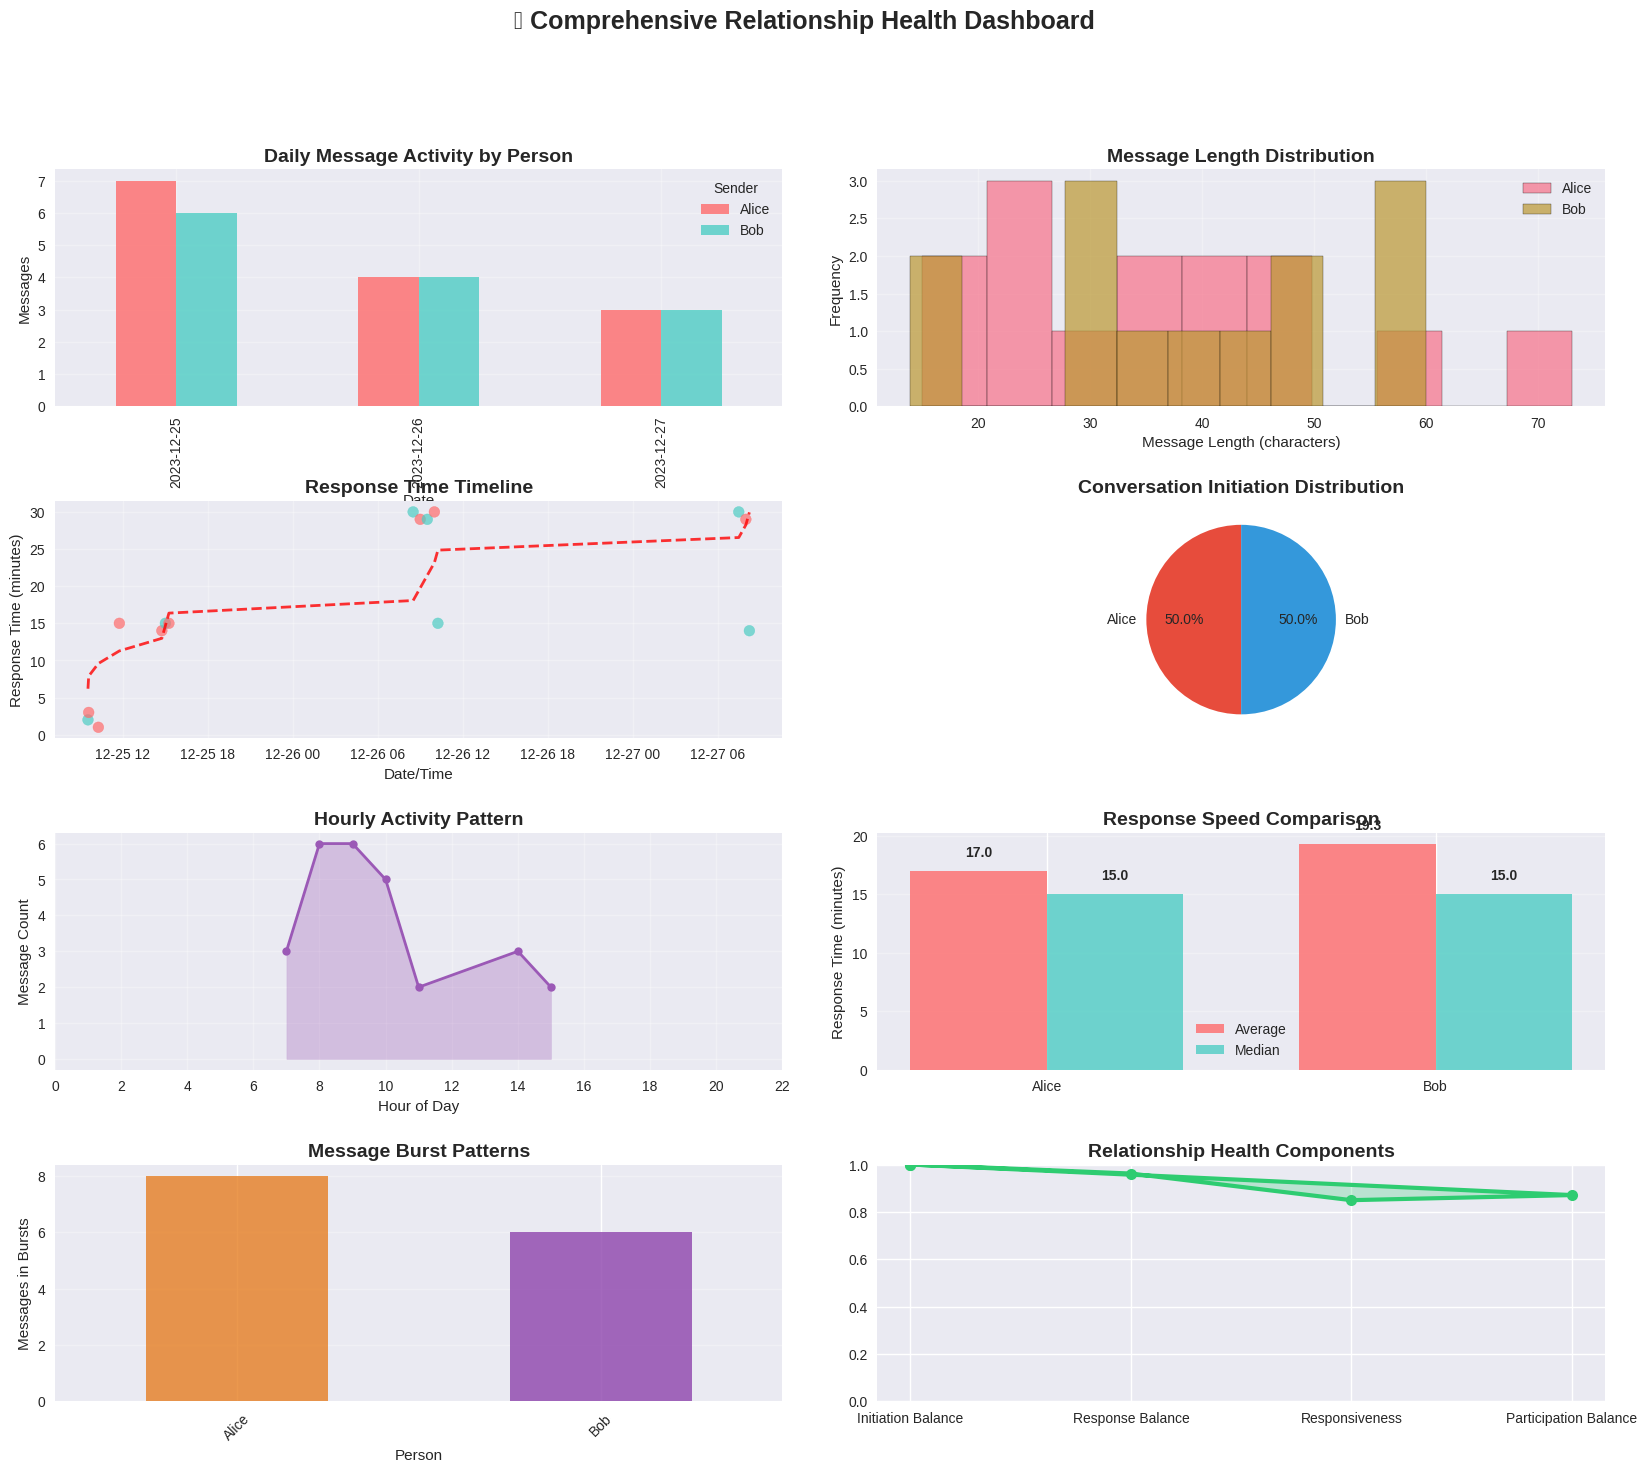


🎯 PRELIMINARY HEALTH SCORE: 0.921
📈 Status: Excellent


In [36]:
# CREATE COMPREHENSIVE VISUALIZATIONS
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 4, hspace=0.4, wspace=0.3)

# 1. Conversation Timeline
ax1 = fig.add_subplot(gs[0, :2])
df_prepared['date'] = df_prepared['datetime'].dt.date
daily_messages = df_prepared.groupby(['date', 'sender']).size().unstack(fill_value=0)
daily_messages.plot(kind='bar', ax=ax1, color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
ax1.set_title('Daily Message Activity by Person', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Messages')
ax1.legend(title='Sender')
ax1.grid(True, alpha=0.3)

# 2. Message Length Distribution
ax2 = fig.add_subplot(gs[0, 2:])
for person in df['sender'].unique():
    person_data = df[df['sender'] == person]['message_length']
    ax2.hist(person_data, alpha=0.7, label=person, bins=10, edgecolor='black')
ax2.set_title('Message Length Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Message Length (characters)')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Response Time Analysis
ax3 = fig.add_subplot(gs[1, :2])
if 'response_analysis_df' in response_metrics:
    response_df = response_metrics['response_analysis_df']
    # Create response time timeline
    ax3.scatter(response_df['datetime'], response_df['response_time_minutes'],
               c=[['#FF6B6B', '#4ECDC4'][i] for i in [0 if x=='Alice' else 1 for x in response_df['responder']]],
               alpha=0.7, s=60)
    ax3.set_title('Response Time Timeline', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Date/Time')
    ax3.set_ylabel('Response Time (minutes)')
    ax3.grid(True, alpha=0.3)

    # Add trend line
    from scipy.stats import linregress
    x_numeric = np.arange(len(response_df))
    slope, intercept, _, _, _ = linregress(x_numeric, response_df['response_time_minutes'])
    ax3.plot(response_df['datetime'], slope * x_numeric + intercept, 'r--', alpha=0.8, linewidth=2)

# 4. Conversation Initiation Patterns
ax4 = fig.add_subplot(gs[1, 2:])
initiator_counts = initiator_results['initiator_counts']
colors = ['#E74C3C', '#3498DB']
wedges, texts, autotexts = ax4.pie(initiator_counts.values(), labels=initiator_counts.keys(),
                                  autopct='%1.1f%%', colors=colors, startangle=90)
ax4.set_title('Conversation Initiation Distribution', fontsize=14, fontweight='bold')

# 5. Hourly Activity Pattern
ax5 = fig.add_subplot(gs[2, :2])
hourly_activity = df.groupby('hour').size()
ax5.plot(hourly_activity.index, hourly_activity.values, marker='o', linewidth=2, markersize=6, color='#9B59B6')
ax5.fill_between(hourly_activity.index, hourly_activity.values, alpha=0.3, color='#9B59B6')
ax5.set_title('Hourly Activity Pattern', fontsize=14, fontweight='bold')
ax5.set_xlabel('Hour of Day')
ax5.set_ylabel('Message Count')
ax5.grid(True, alpha=0.3)
ax5.set_xticks(range(0, 24, 2))

# 6. Response Speed Comparison
ax6 = fig.add_subplot(gs[2, 2:])
if 'response_stats' in response_metrics and 'mean' in response_metrics['response_stats']:
    people = list(response_metrics['response_stats']['mean'].keys())
    avg_response = list(response_metrics['response_stats']['mean'].values())
    median_response = list(response_metrics['response_stats']['median'].values())

    x = np.arange(len(people))
    width = 0.35

    bars1 = ax6.bar(x - width/2, avg_response, width, label='Average', color='#FF6B6B', alpha=0.8)
    bars2 = ax6.bar(x + width/2, median_response, width, label='Median', color='#4ECDC4', alpha=0.8)

    ax6.set_title('Response Speed Comparison', fontsize=14, fontweight='bold')
    ax6.set_ylabel('Response Time (minutes)')
    ax6.set_xticks(x)
    ax6.set_xticklabels(people)
    ax6.legend()
    ax6.grid(True, alpha=0.3, axis='y')

    # Add value labels
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

# 7. Message Burst Analysis
ax7 = fig.add_subplot(gs[3, :2])
# Calculate consecutive messages
df_prepared['is_burst'] = False
df_prepared['burst_id'] = 0
current_sender = None
burst_id = 0
burst_count = 0

for i in range(len(df_prepared)):
    if df_prepared.iloc[i]['sender'] == current_sender:
        burst_count += 1
        df_prepared.iloc[i, df_prepared.columns.get_loc('burst_id')] = burst_id
        if burst_count > 1:
            df_prepared.iloc[i, df_prepared.columns.get_loc('is_burst')] = True
            df_prepared.iloc[i-1, df_prepared.columns.get_loc('is_burst')] = True
    else:
        current_sender = df_prepared.iloc[i]['sender']
        burst_count = 1
        burst_id += 1
        df_prepared.iloc[i, df_prepared.columns.get_loc('burst_id')] = burst_id

burst_stats = df_prepared[df_prepared['is_burst']].groupby('sender').size()
if not burst_stats.empty:
    burst_stats.plot(kind='bar', ax=ax7, color=['#E67E22', '#8E44AD'], alpha=0.8)
    ax7.set_title('Message Burst Patterns', fontsize=14, fontweight='bold')
    ax7.set_ylabel('Messages in Bursts')
    ax7.set_xlabel('Person')
    ax7.tick_params(axis='x', rotation=45)
    ax7.grid(True, alpha=0.3, axis='y')

# 8. Relationship Health Score Gauge
ax8 = fig.add_subplot(gs[3, 2:])

# Calculate preliminary health score
health_components = {
    'Initiation Balance': initiator_results['balance_score'],
    'Response Balance': response_metrics.get('response_balance_score', 1.0),
    'Responsiveness': response_metrics.get('responsiveness_score', 0.5),
    'Participation Balance': dominance_metrics['composite_dominance_score']
}

# Create radar chart
angles = np.linspace(0, 2*np.pi, len(health_components), endpoint=False).tolist()
values = list(health_components.values())
angles += angles[:1]
values += values[:1]

ax8.plot(angles, values, 'o-', linewidth=3, color='#2ECC71', markersize=8)
ax8.fill(angles, values, alpha=0.25, color='#2ECC71')
ax8.set_xticks(angles[:-1])
ax8.set_xticklabels(health_components.keys(), fontsize=10)
ax8.set_ylim(0, 1)
ax8.set_title('Relationship Health Components', fontsize=14, fontweight='bold')
ax8.grid(True)

# Add score in center
overall_score = np.mean(list(health_components.values()))

plt.suptitle('📊 Comprehensive Relationship Health Dashboard', fontsize=18, fontweight='bold', y=0.98)
plt.show()

print(f"\n🎯 PRELIMINARY HEALTH SCORE: {overall_score:.3f}")
print(f"📈 Status: {'Excellent' if overall_score > 0.9 else 'Very Good' if overall_score > 0.8 else 'Good' if overall_score > 0.7 else 'Fair'}")

##Cell 8 : Calculate final weighted health score and create summary report

In [38]:
def calculate_final_relationship_health_score(initiator_metrics, response_metrics, dominance_metrics):
    """Calculate the final weighted relationship health score"""

    # Define weights based on importance
    weights = {
        'initiation_balance': 0.20,      # 20% - who starts conversations
        'responsiveness': 0.30,          # 30% - how quickly they respond
        'response_balance': 0.25,        # 25% - balance in response patterns
        'participation_balance': 0.25    # 25% - overall conversation balance
    }

    # Extract component scores
    initiation_score = initiator_metrics['balance_score']
    responsiveness_score = response_metrics.get('responsiveness_score', 0.5)
    response_balance_score = response_metrics.get('response_balance_score', 1.0)
    participation_score = dominance_metrics['composite_dominance_score']

    # Calculate weighted score
    final_score = (
        weights['initiation_balance'] * initiation_score +
        weights['responsiveness'] * responsiveness_score +
        weights['response_balance'] * response_balance_score +
        weights['participation_balance'] * participation_score
    )

    # Convert to 0-100 scale
    final_score_100 = final_score * 100

    # Grade and recommendations
    if final_score >= 0.90:
        grade = "A+ (Excellent)"
        status = "🟢 HEALTHY"
        description = "Outstanding relationship with excellent communication balance"
        recommendations = ["✅ Maintain current communication patterns", "✅ Continue being responsive to each other"]
    elif final_score >= 0.80:
        grade = "A (Very Good)"
        status = "🟢 HEALTHY"
        description = "Very good relationship with strong communication patterns"
        recommendations = ["✅ Great balance overall", "💡 Minor tweaks could make it perfect"]
    elif final_score >= 0.70:
        grade = "B (Good)"
        status = "🟡 MOSTLY HEALTHY"
        description = "Good relationship with some areas for improvement"
        recommendations = ["💡 Work on response time balance", "💡 Share conversation initiation more equally"]
    elif final_score >= 0.60:
        grade = "C (Fair)"
        status = "🟡 NEEDS ATTENTION"
        description = "Decent relationship but some communication imbalances"
        recommendations = ["⚠️ Address response time differences", "⚠️ Improve conversation balance"]
    else:
        grade = "D (Needs Improvement)"
        status = "🔴 CONCERNING"
        description = "Significant communication imbalances affecting relationship health"
        recommendations = ["🚨 Major improvement needed", "🚨 Consider discussing communication patterns"]

    # Identify strengths
    strengths = []
    if initiation_score >= 0.8:
        strengths.append("🎯 Excellent initiation balance")
    if responsiveness_score >= 0.8:
        strengths.append("⚡ Very responsive communication")
    if response_balance_score >= 0.8:
        strengths.append("⚖️ Balanced response patterns")
    if participation_score >= 0.8:
        strengths.append("🤝 Equal participation")

    # Areas for improvement
    improvements = []
    if initiation_score < 0.7:
        improvements.append("📢 Share conversation initiation more equally")
    if responsiveness_score < 0.7:
        improvements.append("⏰ Improve response times")
    if response_balance_score < 0.7:
        improvements.append("⚖️ Balance response speed differences")
    if participation_score < 0.7:
        improvements.append("💬 Balance message participation")

    return {
        'final_score': final_score,
        'final_score_100': final_score_100,
        'grade': grade,
        'status': status,
        'description': description,
        'component_scores': {
            'initiation_balance': initiation_score,
            'responsiveness': responsiveness_score,
            'response_balance': response_balance_score,
            'participation_balance': participation_score
        },
        'weights': weights,
        'strengths': strengths,
        'recommendations': recommendations,
        'improvements': improvements
    }

# Calculate final health score
final_health = calculate_final_relationship_health_score( initiator_results, response_metrics, dominance_metrics)

In [39]:
print(f"📊 OVERALL HEALTH SCORE: {final_health['final_score_100']:.1f}/100")
print(f"🎯 GRADE: {final_health['grade']}")
print(f"📈 STATUS: {final_health['status']}")
print(f"💡 DESCRIPTION: {final_health['description']}")

📊 OVERALL HEALTH SCORE: 91.3/100
🎯 GRADE: A+ (Excellent)
📈 STATUS: 🟢 HEALTHY
💡 DESCRIPTION: Outstanding relationship with excellent communication balance


In [40]:
print(f"\n📋 DETAILED COMPONENT BREAKDOWN:")
print(f"  • Initiation Balance: {final_health['component_scores']['initiation_balance']:.3f} (Weight: {final_health['weights']['initiation_balance']:.1%})")
print(f"  • Responsiveness: {final_health['component_scores']['responsiveness']:.3f} (Weight: {final_health['weights']['responsiveness']:.1%})")
print(f"  • Response Balance: {final_health['component_scores']['response_balance']:.3f} (Weight: {final_health['weights']['response_balance']:.1%})")
print(f"  • Participation Balance: {final_health['component_scores']['participation_balance']:.3f} (Weight: {final_health['weights']['participation_balance']:.1%})")


📋 DETAILED COMPONENT BREAKDOWN:
  • Initiation Balance: 1.000 (Weight: 20.0%)
  • Responsiveness: 0.849 (Weight: 30.0%)
  • Response Balance: 0.962 (Weight: 25.0%)
  • Participation Balance: 0.871 (Weight: 25.0%)


In [41]:
print(f"\n✅ RELATIONSHIP STRENGTHS:")
for strength in final_health['strengths']:
    print(f"  {strength}")

if final_health['improvements']:
    print(f"\n💡 AREAS FOR IMPROVEMENT:")
    for improvement in final_health['improvements']:
        print(f"  {improvement}")

print(f"\n🎯 RECOMMENDATIONS:")
for rec in final_health['recommendations']:
    print(f"  {rec}")


✅ RELATIONSHIP STRENGTHS:
  🎯 Excellent initiation balance
  ⚡ Very responsive communication
  ⚖️ Balanced response patterns
  🤝 Equal participation

🎯 RECOMMENDATIONS:
  ✅ Maintain current communication patterns
  ✅ Continue being responsive to each other


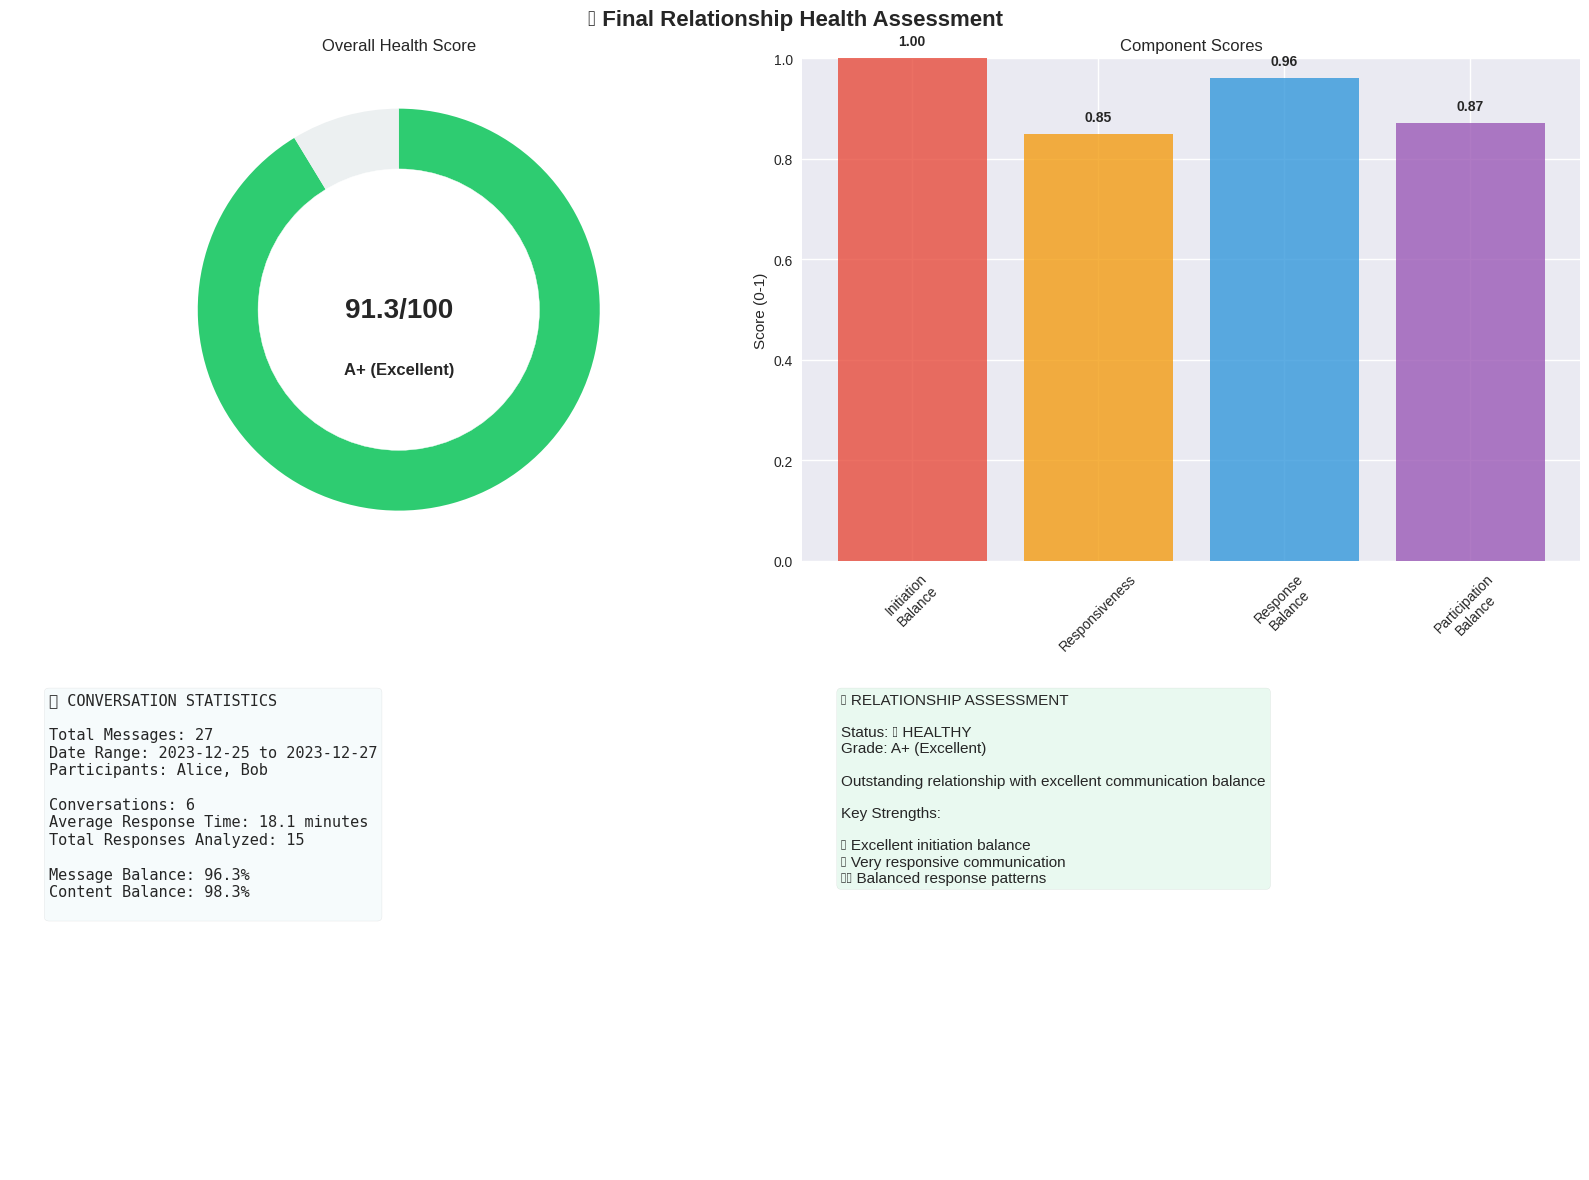


🎉 DAY 5 COMPLETED: Relationship Health Metrics Analysis
✅ Alice & Bob's relationship shows 🟢 HEALTHY with a score of 91.3/100!
📅 Ready for Day 6: PDF Report Generator


In [42]:
# Create final summary visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🏥 Final Relationship Health Assessment', fontsize=16, fontweight='bold')

# 1. Score gauge
ax1.pie([final_health['final_score'], 1-final_health['final_score']],
        colors=['#2ECC71', '#ECF0F1'], startangle=90, counterclock=False)
circle = plt.Circle((0,0), 0.7, color='white')
ax1.add_artist(circle)
ax1.text(0, 0, f"{final_health['final_score_100']:.1f}/100", ha='center', va='center',
         fontsize=20, fontweight='bold')
ax1.text(0, -0.3, f"{final_health['grade']}", ha='center', va='center',
         fontsize=12, fontweight='bold')
ax1.set_title('Overall Health Score')

# 2. Component scores
components = ['Initiation\nBalance', 'Responsiveness', 'Response\nBalance', 'Participation\nBalance']
scores = list(final_health['component_scores'].values())
colors = ['#E74C3C', '#F39C12', '#3498DB', '#9B59B6']

bars = ax2.bar(components, scores, color=colors, alpha=0.8)
ax2.set_ylim(0, 1)
ax2.set_title('Component Scores')
ax2.set_ylabel('Score (0-1)')
ax2.tick_params(axis='x', rotation=45)

for bar, score in zip(bars, scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{score:.2f}', ha='center', va='bottom', fontweight='bold')

# 3. Conversation stats summary
ax3.axis('off')
stats_text = f"""📊 CONVERSATION STATISTICS

Total Messages: {len(df)}
Date Range: {df['datetime'].min().strftime('%Y-%m-%d')} to {df['datetime'].max().strftime('%Y-%m-%d')}
Participants: {', '.join(df['sender'].unique())}

Conversations: {initiator_results['total_conversations']}
Average Response Time: {response_metrics['overall_avg_response_minutes']:.1f} minutes
Total Responses Analyzed: {response_metrics['total_responses_analyzed']}

Message Balance: {dominance_metrics['message_count_balance']:.1%}
Content Balance: {dominance_metrics['message_length_balance']:.1%}
"""

ax3.text(0.05, 0.95, stats_text, transform=ax3.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.1))

# 4. Health status summary
ax4.axis('off')
status_color = '#2ECC71' if 'HEALTHY' in final_health['status'] else '#F39C12' if 'ATTENTION' in final_health['status'] else '#E74C3C'

summary_text = f"""🎯 RELATIONSHIP ASSESSMENT

Status: {final_health['status']}
Grade: {final_health['grade']}

{final_health['description']}

Key Strengths:
"""

for strength in final_health['strengths'][:3]:  # Show top 3
    summary_text += f"\n{strength}"

if final_health['improvements']:
    summary_text += f"\n\nNext Steps:"
    for imp in final_health['improvements'][:2]:  # Show top 2
        summary_text += f"\n{imp}"

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor=status_color, alpha=0.1))

plt.tight_layout()
plt.show()

print(f"\n🎉 DAY 5 COMPLETED: Relationship Health Metrics Analysis")
print(f"✅ Alice & Bob's relationship shows {final_health['status']} with a score of {final_health['final_score_100']:.1f}/100!")
print(f"📅 Ready for Day 6: PDF Report Generator")